In [1]:
from matplotlib import pyplot as plt, colors as mcolors, colormaps
import numpy as np
from scipy.spatial.distance import cosine as cos_dist
from sklearn.decomposition import PCA

In [9]:
def spec_norm(spectrum):
    """ normalize spectrum such that all intensities sum to 1 """
    mz, i = np.array(spectrum)
    return np.array([mz, i / sum(i)])


def spec_entropy(spectrum):
    """ compute spectral entropy for single spectrum """
    mz, i = spectrum
    return -np.sum(i * np.log(i))
    

def spec_combine(spectra, comb_mztol=0.1):
    """ combine multiple spectra into a single spectrum """
    comb_mz, comb_i = [], []
    # iterate through spectra in set
    # combine m/zs that are within tolerance of one another
    # otherwise just add the new points
    for spectrum in spectra:
        for mz, i in zip(*spectrum):
            added = False
            for j in range(len(comb_mz)):
                if abs(mz - comb_mz[j]) <= comb_mztol:
                    comb_i[j] += i
                    added = True
            if not added:
                comb_mz.append(mz)
                comb_i.append(i)
    # sort by m/z
    idx = np.argsort(comb_mz)
    comb_mz, comb_i = np.array(comb_mz)[idx], np.array(comb_i)[idx]
    # return normalized spectrum
    return spec_norm([comb_mz, comb_i])


def spec_entropy_similarity(spectrum_A, spectrum_B):
    """ pairwise spectral entropy based similarity as defined in the paper """
    spectrum_AB = spec_combine([spectrum_A, spectrum_B])
    s_AB, s_A, s_B = spec_entropy(spectrum_AB), spec_entropy(spectrum_A), spec_entropy(spectrum_B)
    return 1. - ((2. * s_AB - s_A - s_B) / np.log(4.))

In [10]:
def bin_together(spectra):
    """ perform binning at unit m/z intervals for a set of spectra """
    bins = np.arange(np.floor(min([min(_[0]) for _ in spectra])),
                     np.ceil(max([max(_[0]) for _ in spectra])) + 1,
                     1.)
    vecs = []
    for spectrum in spectra:
        vec = np.zeros(bins.shape)
        for mz, i in zip(*spectrum):
            vec[np.argmin(np.abs(mz - bins))] += i
        vecs.append(vec / sum(vec))
    return bins, vecs


def cosine_similarity(spectrum_A, spectrum_B):
    """ typical cosine similarity metric """
    # bin the input vectors 
    bins, vecs = bin_together([spectrum_A, spectrum_B])
    return 1 - cos_dist(*vecs)

In [11]:
color = lambda cmap, vmin, vmax, v: colormaps[cmap](mcolors.Normalize(vmin=vmin, vmax=vmax)(v))

In [12]:
def plot_spectra_series(spectra, ce, cmap, w=1.5):
    n = len(spectra)
    minx, maxx = min([min(_[0]) for _ in spectra]), max([max(_[0]) for _ in spectra])
    fig, axs = plt.subplots(nrows=n, figsize=(3.33, 0.5 * n + 1))
    for i in range(n):
        ax = axs[n - i - 1]
        ax.bar(*spectra[i], w, color=color(cmap, min(ce), max(ce) + 5, ce[i]), label=ce[i])
        ax.set_xlim([minx - 20, maxx + 20])
        for d in ['top', 'right']:
            ax.spines[d].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel(ce[i])
        if i > 0:
            ax.set_xticks([])
    #plt.savefig(fname, dpi=350, bbox_inches='tight')
    plt.show()
    plt.close()
    

In [13]:
def pca_analysis(ce, spectra, combined):
    bins, binned = bin_together([combined] + spectra)
    pca2 = PCA(n_components=2).fit(binned[1:])
    fig, ax = plt.subplots(figsize=(4, 4))
    cs = [color('plasma', min(ce), max(ce) + 5, _) for _ in ce]
    proj = pca2.transform(binned)
    ax.scatter(*proj[1:].T, edgecolor=cs, color=(0, 0, 0, 0), marker='o', s=32)
    ax.scatter(*proj[0].T, color='k', marker='+', s=60)
    for d in ['top', 'right', 'bottom', 'left']:
        ax.spines[d].set_visible(False)
    ax.set_xlabel('PC1 ({:.1f} %)'.format(100. * pca2.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.1f} %)'.format(100. * pca2.explained_variance_ratio_[1]))
    ax.axvline(0, c='grey', lw=1, ls='--', zorder=-1)
    ax.axhline(0, c='grey', lw=1, ls='--', zorder=-1)
    plt.show()
    plt.close()

In [17]:
def pca_analysis_2(ce_A, spectra_A, combined_A, ce_B, spectra_B, combined_B):
    bins, binned = bin_together([combined_A] + spectra_A + [combined_B] + spectra_B)
    pca2 = PCA(n_components=2).fit(binned[1:])
    fig, ax = plt.subplots(figsize=(4, 4))
    cs_A = [color('Reds', min(ce_A) - 5, max(ce_A) + 5, _) for _ in ce_A]
    cs_B = [color('Blues', min(ce_B) - 5, max(ce_B) + 5, _) for _ in ce_B]
    proj = pca2.transform(binned)
    ax.scatter(*proj[1:len(spectra_A) + 1].T, edgecolor=cs_A, color=(0, 0, 0, 0), marker='o', s=32)
    ax.scatter(*proj[len(spectra_A) + 2:len(spectra_A) + 2 + len(spectra_B)].T, edgecolor=cs_B, color=(0, 0, 0, 0), marker='o', s=32)
    ax.scatter(*proj[0].T, color='r', marker='+', s=60)
    ax.scatter(*proj[len(spectra_A) + 1].T, color='b', marker='+', s=60)
    for d in ['top', 'right', 'bottom', 'left']:
        ax.spines[d].set_visible(False)
    ax.set_xlabel('PC1 ({:.1f} %)'.format(100. * pca2.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.1f} %)'.format(100. * pca2.explained_variance_ratio_[1]))
    ax.axvline(0, c='grey', lw=1, ls='--', zorder=-1)
    ax.axhline(0, c='grey', lw=1, ls='--', zorder=-1)
    plt.show()
    plt.close()

In [18]:
def series_comparison(ce_A, spectra_A, ce_B, spectra_B):
    spectra_A = [spec_norm(spectrum) for spectrum in spectra_A]

    spectra_B = [spec_norm(spectrum) for spectrum in spectra_B]

    combined_A = spec_combine(spectra_A)
    combined_B = spec_combine(spectra_B)

    plot_spectra_series(spectra_A + [combined_A], ce_A + [0], 'plasma')
    
    pca_analysis(ce_A, spectra_A, combined_A)
    
    plot_spectra_series(spectra_B + [combined_B], ce_B + [0], 'plasma')

    pca_analysis(ce_B, spectra_B, combined_B)

    pca_analysis_2(ce_A, spectra_A, combined_A, ce_B, spectra_B, combined_B)
    
    print('spec. entropy A', spec_entropy(combined_A))
    print('spec. entropy B', spec_entropy(combined_B))

    print('spec. entropy similarity (A & B):', spec_entropy_similarity(combined_A, combined_B))
    print('cosine similarirt (A & B):', cosine_similarity(combined_A, combined_B))


    combA_toA = [spec_entropy_similarity(combined_A, spectrum) for spectrum in spectra_A]
    combA_toB = [spec_entropy_similarity(combined_A, spectrum) for spectrum in spectra_B]

    combB_toB = [spec_entropy_similarity(combined_B, spectrum) for spectrum in spectra_B]
    combB_toA = [spec_entropy_similarity(combined_B, spectrum) for spectrum in spectra_A]


    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ce_A, combA_toA, ls='-', marker='.', c='red', label='combA->A')
    ax.plot(ce_B, combA_toB, ls='-', marker='.', c='pink', label='combA->B')
    ax.plot(ce_B, combB_toB, ls='-', marker='.', c='blue', label='combB->B')
    ax.plot(ce_A, combB_toA, ls='-', marker='.', c='aqua', label='combB->A')

    for d in ['top', 'right']:
        ax.spines[d].set_visible(False)
    ax.set_xlabel('CV')
    ax.set_ylabel('spec. entropy sim.')
    ax.set_ylim([0, 1.])
    ax.legend(frameon=False)
    plt.show()
    plt.close()

    combA_toA = [cosine_similarity(combined_A, spectrum) for spectrum in spectra_A]
    combA_toB = [cosine_similarity(combined_A, spectrum) for spectrum in spectra_B]

    combB_toB = [cosine_similarity(combined_B, spectrum) for spectrum in spectra_B]
    combB_toA = [cosine_similarity(combined_B, spectrum) for spectrum in spectra_A]


    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ce_A, combA_toA, ls='-', marker='.', c='red', label='combA->A')
    ax.plot(ce_B, combA_toB, ls='-', marker='.', c='pink', label='combA->B')
    ax.plot(ce_B, combB_toB, ls='-', marker='.', c='blue', label='combB->B')
    ax.plot(ce_A, combB_toA, ls='-', marker='.', c='aqua', label='combB->A')

    for d in ['top', 'right']:
        ax.spines[d].set_visible(False)
    ax.set_xlabel('CV')
    ax.set_ylabel('cosine sim.')
    ax.set_ylim([0, 1.])
    ax.legend(frameon=False)
    plt.show()
    plt.close()

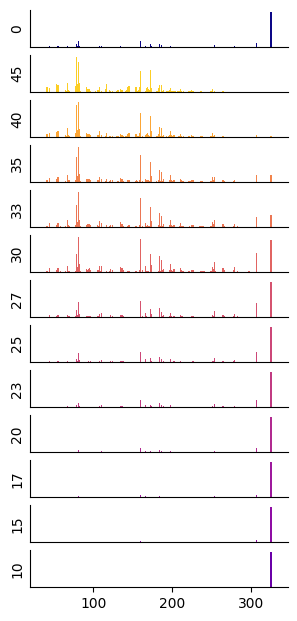

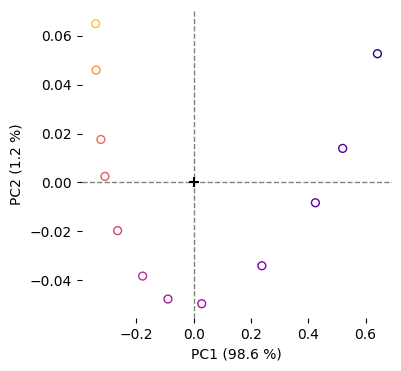

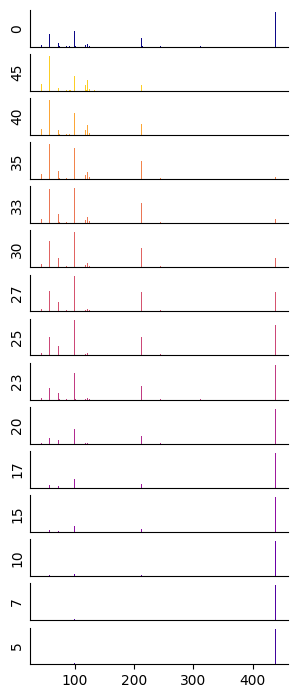

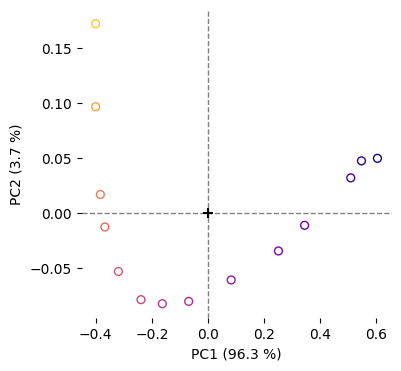

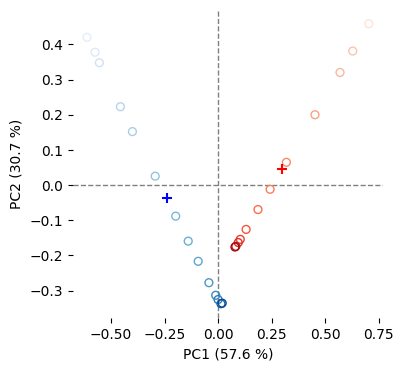

spec. entropy A 3.364476306439162
spec. entropy B 1.9389279508052382
spec. entropy similarity (A & B): 0.030728259009984216
cosine similarirt (A & B): 0.00271695406047201


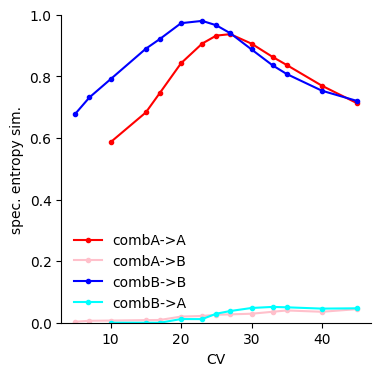

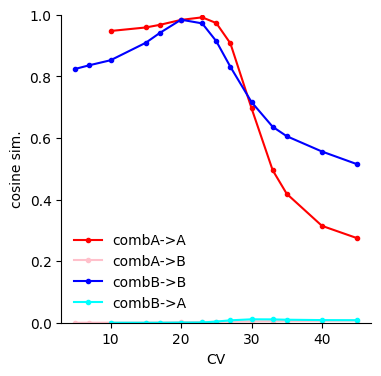

In [19]:
# ! THIS IS THE EXAMPLE I USED !
# FROM NIST20
# A=QUININE, B=TRIPARANOL 
# BOTH [M+H]+ (Q-TOF)
ce_A = [10, 15, 17, 20, 23, 25, 27, 30, 33, 35, 40, 45]
spectra_A = [[[160.07, 307.18, 325.19],[11.49, 17.58, 999.0]],
[[81.07, 110.09, 160.07, 166.12, 184.07, 253.13, 307.18, 325.19, 326.19],[13.39, 12.29, 39.86, 13.79, 17.28, 14.69, 51.85, 999.0, 12.59]],
[[81.07, 110.09, 160.07, 166.12, 172.07, 184.07, 186.09, 198.09, 253.13, 264.13, 279.15, 307.18, 325.19, 326.19],[23.08, 17.98, 60.34, 21.78, 13.09, 29.47, 10.09, 14.49, 24.78, 11.69, 10.79, 74.92, 999.0, 10.09]],
[[44.05, 67.05, 79.05, 81.07, 82.06, 108.08, 110.09, 134.09, 136.11, 138.12, 160.07, 166.12, 172.07, 173.08, 174.09, 184.07, 186.09, 189.08, 198.09, 253.13, 264.14, 279.15, 307.18, 325.19, 326.19],[14.39, 10.09, 21.48, 54.94, 19.38, 16.88, 34.27, 12.89, 15.08, 11.29, 108.59, 37.76, 25.57, 13.19, 13.49, 55.24, 24.78, 11.79, 27.37, 45.15, 18.78, 21.08, 126.17, 999.0, 10.89]],
[[44.05, 55.05, 67.05, 79.05, 80.05, 81.07, 82.06, 93.06, 94.06, 95.08, 96.08, 108.08, 110.09, 122.09, 124.11, 134.09, 136.11, 138.12, 160.07, 162.09, 166.12, 172.07, 173.08, 174.09, 184.07, 186.09, 188.07, 189.07, 198.09, 199.09, 202.08, 210.09, 224.1, 226.12, 227.12, 251.12, 252.13, 253.13, 264.14, 266.15, 278.15, 279.15, 282.15, 297.19, 307.18, 325.19],[20.08, 13.29, 23.98, 50.15, 20.08, 129.27, 42.06, 11.79, 13.29, 15.28, 11.89, 34.37, 58.84, 19.18, 16.68, 26.97, 31.37, 18.28, 209.69, 12.89, 65.83, 66.83, 26.97, 27.47, 105.69, 52.75, 11.19, 22.78, 50.95, 12.79, 16.08, 18.18, 13.09, 15.88, 15.58, 23.68, 16.28, 78.72, 35.36, 10.39, 17.78, 38.86, 15.18, 13.99, 203.1, 999.0]],
[[44.05, 53.04, 55.05, 56.05, 67.05, 68.05, 69.06, 70.06, 79.05, 80.05, 81.07, 82.06, 84.08, 91.05, 93.07, 94.06, 95.08, 96.08, 105.07, 106.06, 107.08, 108.08, 110.09, 117.06, 120.08, 122.09, 124.11, 134.09, 135.1, 136.11, 138.12, 160.07, 162.09, 166.12, 172.07, 173.08, 174.09, 184.07, 185.08, 186.09, 188.07, 189.07, 196.07, 198.09, 199.09, 200.1, 202.08, 210.09, 211.09, 212.1, 213.1, 214.08, 224.1, 226.12, 227.12, 236.1, 238.12, 239.12, 250.12, 251.12, 252.13, 253.13, 254.15, 264.14, 265.13, 266.15, 278.15, 279.15, 282.15, 297.19, 307.18, 325.19, 326.19],[38.36, 10.89, 25.67, 15.38, 42.46, 13.19, 12.19, 15.68, 92.81, 29.27, 246.85, 61.74, 12.49, 15.78, 15.68, 21.78, 19.18, 26.37, 11.79, 11.59, 12.39, 47.75, 75.22, 10.89, 12.69, 30.87, 25.07, 43.46, 11.79, 38.36, 26.67, 280.22, 20.58, 85.61, 120.78, 49.65, 40.86, 156.44, 13.09, 86.51, 15.48, 33.47, 13.69, 86.71, 18.58, 13.99, 25.87, 31.37, 11.69, 14.59, 14.89, 10.79, 21.48, 28.87, 27.57, 13.29, 12.69, 12.89, 12.59, 38.56, 28.77, 123.98, 12.49, 49.25, 19.08, 16.08, 27.07, 55.64, 20.18, 18.98, 296.5, 999.0, 12.59]],
[[41.04, 42.03, 44.05, 53.04, 55.05, 56.05, 58.06, 67.05, 68.05, 69.06, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 84.08, 91.05, 93.07, 94.06, 95.08, 96.08, 105.07, 106.06, 107.08, 108.08, 109.09, 110.09, 117.06, 120.08, 122.09, 124.11, 134.09, 135.1, 136.11, 138.12, 143.07, 145.05, 148.11, 154.06, 155.07, 158.06, 159.07, 160.07, 162.09, 166.12, 167.07, 169.05, 172.07, 173.08, 174.09, 182.06, 183.07, 184.07, 185.08, 186.09, 188.07, 189.08, 196.07, 197.08, 198.09, 199.09, 200.1, 202.08, 210.09, 211.09, 212.1, 213.1, 214.08, 224.1, 225.1, 226.12, 227.12, 236.1, 237.1, 238.12, 239.12, 240.13, 248.1, 249.11, 250.12, 251.12, 252.13, 253.13, 254.15, 262.12, 263.12, 264.14, 265.13, 266.15, 278.15, 279.15, 282.15, 296.16, 297.19, 307.18, 325.19],[12.39, 13.29, 60.14, 23.68, 52.05, 25.27, 12.79, 75.42, 23.08, 24.58, 29.67, 22.98, 190.11, 55.14, 440.16, 97.6, 16.38, 26.97, 34.67, 34.37, 43.06, 38.46, 23.18, 19.88, 25.37, 84.02, 10.29, 109.89, 21.38, 14.59, 50.25, 40.16, 65.73, 17.48, 71.53, 37.76, 11.09, 15.08, 11.69, 11.19, 15.88, 17.68, 14.19, 454.45, 27.57, 112.59, 22.78, 13.39, 218.08, 85.71, 75.22, 12.39, 13.49, 255.54, 20.98, 138.46, 24.18, 56.24, 29.77, 19.08, 130.17, 36.56, 18.18, 40.76, 50.95, 21.28, 27.97, 23.18, 15.68, 39.36, 19.48, 41.36, 42.66, 21.58, 12.99, 20.08, 17.88, 11.09, 11.09, 11.89, 17.08, 59.04, 49.05, 186.11, 15.18, 13.29, 12.99, 71.93, 35.06, 27.67, 42.36, 83.42, 25.57, 11.79, 19.98, 389.01, 999.0]],
[[41.04, 42.03, 43.05, 44.05, 53.04, 55.05, 56.05, 57.06, 58.06, 65.04, 66.04, 67.05, 68.05, 69.05, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 83.07, 84.08, 91.05, 93.07, 94.06, 95.08, 96.08, 105.07, 106.06, 107.08, 108.08, 109.09, 110.09, 115.05, 117.06, 119.08, 120.08, 121.08, 122.09, 124.11, 131.07, 132.08, 134.09, 135.1, 136.11, 138.12, 143.07, 144.08, 145.05, 148.11, 154.06, 155.07, 156.07, 158.06, 159.06, 160.07, 161.07, 162.09, 166.12, 167.07, 168.08, 169.05, 170.06, 171.06, 172.07, 173.08, 174.09, 176.07, 180.08, 181.08, 182.06, 183.07, 184.07, 185.08, 186.09, 187.09, 188.07, 189.08, 193.08, 195.07, 196.07, 197.08, 198.09, 199.09, 200.1, 202.08, 204.08, 205.08, 206.09, 209.08, 210.09, 211.09, 212.1, 213.1, 214.09, 218.09, 219.09, 221.1, 222.09, 223.09, 224.1, 225.1, 226.12, 227.12, 233.12, 234.09, 236.1, 237.1, 238.12, 239.12, 240.13, 247.12, 248.1, 249.11, 250.12, 251.12, 252.13, 253.13, 254.15, 262.12, 262.13, 263.12, 264.14, 265.13, 266.15, 276.15, 277.13, 278.15, 279.15, 280.17, 282.15, 292.15, 296.16, 297.19, 307.18, 325.19, 326.19],[35.06, 43.56, 11.99, 127.87, 56.14, 129.57, 53.65, 10.59, 28.17, 24.48, 12.49, 184.42, 40.16, 37.96, 44.95, 43.66, 499.3, 152.75, 999.0, 225.57, 14.39, 30.87, 80.12, 77.22, 80.72, 107.79, 63.14, 66.33, 54.65, 51.35, 164.44, 24.18, 172.13, 16.48, 47.45, 15.78, 43.26, 14.59, 81.52, 77.32, 15.08, 12.69, 138.16, 34.67, 110.29, 58.44, 27.47, 14.79, 44.76, 20.58, 29.07, 40.86, 12.49, 52.25, 40.66, 920.38, 10.39, 56.34, 182.42, 35.26, 18.08, 32.97, 26.67, 19.58, 519.28, 191.71, 159.24, 10.89, 12.09, 16.48, 30.27, 45.65, 456.04, 43.06, 352.25, 20.08, 56.24, 96.3, 12.19, 12.99, 65.13, 47.05, 234.67, 74.73, 36.76, 86.41, 12.09, 10.79, 10.49, 18.08, 106.39, 50.35, 48.15, 44.26, 45.15, 10.09, 10.69, 26.97, 26.47, 11.99, 67.23, 39.66, 74.83, 77.52, 14.39, 18.18, 42.96, 36.26, 38.96, 31.27, 22.08, 10.19, 24.78, 31.17, 35.96, 152.55, 92.51, 295.5, 26.47, 10.19, 12.89, 18.28, 114.69, 56.54, 49.75, 12.59, 17.48, 56.94, 141.86, 10.69, 39.86, 11.69, 20.78, 25.47, 527.97, 899.5, 12.39]],
[[41.04, 42.03, 44.05, 53.04, 55.05, 56.05, 57.06, 58.06, 65.04, 66.04, 67.05, 68.05, 69.06, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 83.07, 84.08, 91.05, 93.07, 94.06, 95.08, 96.08, 105.07, 106.06, 107.08, 108.08, 109.09, 110.09, 115.05, 117.06, 119.08, 120.08, 121.08, 122.09, 124.11, 131.07, 132.08, 134.09, 135.1, 136.11, 138.12, 142.06, 143.07, 144.07, 145.05, 148.11, 154.06, 155.07, 156.07, 157.05, 158.06, 159.06, 160.07, 162.09, 166.06, 166.12, 167.07, 168.07, 169.05, 170.06, 171.07, 172.07, 173.08, 174.09, 180.08, 181.08, 182.06, 183.07, 184.07, 185.08, 186.09, 187.1, 188.07, 189.08, 192.08, 193.08, 195.09, 196.07, 197.08, 198.09, 199.09, 200.08, 200.1, 202.08, 204.08, 206.09, 207.1, 209.08, 210.09, 211.09, 212.1, 213.1, 214.09, 218.09, 219.09, 220.1, 221.1, 222.09, 223.09, 224.1, 225.1, 226.12, 227.12, 233.11, 234.09, 236.1, 237.1, 238.12, 239.12, 240.13, 247.12, 248.1, 249.11, 250.12, 251.12, 252.13, 253.13, 254.15, 262.12, 263.12, 264.14, 265.13, 266.15, 277.13, 278.15, 279.15, 282.15, 296.17, 297.19, 307.18, 325.19],[41.86, 41.76, 122.68, 67.43, 133.57, 56.84, 11.59, 24.58, 25.27, 13.39, 201.3, 50.15, 42.76, 45.15, 59.54, 633.07, 154.84, 999.0, 205.29, 10.69, 34.17, 72.83, 78.32, 76.62, 104.4, 65.53, 58.34, 47.25, 46.05, 172.03, 17.68, 128.57, 18.58, 63.24, 15.28, 43.86, 16.58, 73.93, 69.23, 15.58, 13.89, 137.86, 25.97, 104.2, 49.65, 14.39, 43.96, 18.88, 58.94, 12.59, 40.16, 47.35, 16.88, 11.69, 61.74, 52.05, 825.27, 47.55, 14.39, 129.37, 45.55, 27.67, 59.04, 42.36, 22.58, 560.14, 182.62, 139.36, 19.78, 14.29, 28.17, 64.34, 399.7, 37.06, 314.78, 15.98, 44.16, 102.6, 11.79, 14.69, 14.59, 60.24, 47.75, 196.8, 58.94, 15.28, 23.98, 69.93, 15.58, 15.08, 11.59, 21.98, 106.99, 49.05, 45.15, 32.07, 46.45, 12.29, 13.39, 11.19, 21.68, 22.48, 15.08, 71.23, 40.96, 59.74, 52.95, 10.69, 25.17, 40.06, 35.56, 30.17, 28.67, 16.68, 12.29, 22.08, 23.98, 37.76, 135.96, 78.92, 200.8, 17.98, 18.68, 19.08, 82.22, 54.45, 35.66, 17.08, 48.25, 78.32, 25.87, 13.89, 20.48, 293.01, 354.35]],
[[41.04, 42.03, 43.05, 44.05, 53.04, 55.05, 56.05, 58.06, 65.04, 66.04, 67.05, 68.05, 69.06, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 83.07, 84.08, 91.05, 93.06, 94.06, 95.08, 96.08, 105.07, 106.06, 107.08, 108.08, 109.09, 110.09, 115.05, 117.06, 118.06, 119.08, 120.08, 121.08, 122.09, 124.11, 129.06, 130.06, 131.07, 132.08, 134.09, 135.1, 136.11, 138.12, 141.05, 142.06, 143.07, 144.08, 145.05, 146.05, 154.06, 155.07, 156.07, 157.05, 158.06, 159.07, 160.07, 161.07, 162.09, 166.06, 166.12, 167.07, 168.07, 169.05, 170.06, 171.07, 172.07, 173.08, 174.09, 180.08, 181.08, 182.06, 183.07, 184.07, 185.08, 186.09, 187.09, 188.07, 189.07, 192.08, 193.08, 194.09, 195.07, 196.07, 197.08, 198.09, 199.09, 200.08, 200.09, 202.08, 204.08, 205.08, 206.09, 207.1, 208.09, 209.08, 210.09, 211.09, 212.1, 213.1, 214.08, 216.1, 218.09, 219.1, 220.1, 221.1, 222.09, 223.1, 224.1, 225.1, 226.12, 227.12, 233.11, 234.09, 235.09, 236.1, 237.1, 238.12, 239.12, 240.13, 248.1, 249.11, 250.12, 251.12, 252.13, 253.13, 254.15, 262.12, 263.12, 264.14, 265.13, 266.15, 277.13, 278.15, 279.15, 282.15, 307.18, 325.19],[50.85, 41.96, 11.39, 117.38, 98.0, 138.76, 64.74, 21.28, 36.26, 20.98, 202.2, 60.24, 40.96, 54.25, 65.53, 698.7, 172.63, 999.0, 220.98, 10.19, 30.37, 90.81, 80.42, 90.01, 80.92, 62.54, 57.04, 52.15, 44.46, 157.94, 14.59, 102.7, 23.38, 86.81, 12.39, 14.98, 48.65, 14.39, 75.22, 54.55, 16.08, 10.39, 26.97, 15.58, 119.48, 24.58, 85.11, 36.96, 11.49, 21.28, 50.15, 26.07, 62.74, 13.99, 47.35, 65.73, 24.78, 13.49, 74.03, 54.05, 750.35, 10.39, 34.07, 22.88, 97.7, 57.64, 29.27, 69.53, 49.95, 33.67, 563.84, 187.31, 127.87, 23.38, 18.28, 31.37, 73.43, 353.45, 36.06, 287.51, 11.99, 44.06, 94.81, 11.79, 19.28, 13.79, 14.29, 66.03, 50.15, 199.4, 56.14, 23.68, 22.08, 58.34, 16.08, 10.79, 13.69, 14.69, 10.79, 19.28, 105.49, 51.95, 40.06, 25.47, 41.46, 11.09, 12.69, 11.89, 15.28, 29.07, 19.08, 23.88, 70.93, 40.36, 62.74, 47.15, 13.29, 17.98, 13.39, 39.76, 39.86, 38.06, 20.38, 11.79, 23.48, 27.77, 37.36, 144.26, 63.04, 152.85, 15.78, 12.59, 19.58, 64.24, 53.35, 26.47, 20.48, 30.57, 58.44, 17.48, 195.8, 202.3]],
[[41.04, 42.03, 43.05, 44.05, 51.02, 53.04, 54.03, 55.05, 56.05, 57.05, 58.06, 65.04, 66.04, 67.05, 68.05, 69.06, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 83.07, 84.08, 91.05, 93.06, 94.06, 95.08, 96.08, 103.05, 105.07, 106.06, 107.08, 108.08, 109.08, 110.09, 115.05, 117.06, 118.06, 119.08, 120.08, 121.08, 122.09, 124.11, 129.06, 130.06, 131.07, 132.08, 134.09, 135.1, 136.11, 138.12, 141.05, 142.06, 143.07, 144.08, 145.05, 146.06, 154.06, 155.07, 156.07, 157.05, 158.06, 159.06, 160.07, 162.09, 166.06, 166.12, 167.07, 168.07, 169.05, 170.06, 171.07, 172.07, 173.08, 174.08, 180.08, 181.08, 182.06, 183.07, 184.07, 185.08, 186.09, 187.09, 188.07, 189.07, 192.08, 193.08, 194.09, 195.07, 196.07, 197.08, 198.09, 199.08, 200.07, 200.1, 202.08, 204.08, 205.08, 206.09, 207.09, 208.09, 209.09, 210.09, 211.09, 212.1, 213.1, 214.08, 218.09, 219.1, 220.08, 221.11, 222.09, 223.1, 224.1, 225.1, 226.12, 227.12, 232.11, 234.09, 235.09, 236.1, 237.1, 238.12, 239.12, 248.1, 249.11, 250.12, 251.12, 252.13, 253.13, 262.12, 263.12, 264.14, 265.13, 266.15, 277.13, 278.15, 279.15, 307.18, 325.19],[101.7, 43.26, 11.39, 132.47, 10.49, 153.45, 10.99, 185.01, 72.73, 16.98, 19.28, 62.64, 24.38, 249.75, 62.44, 43.66, 47.65, 110.79, 901.1, 196.0, 999.0, 235.56, 13.69, 34.87, 122.88, 79.02, 100.3, 105.39, 49.75, 16.48, 56.84, 62.34, 38.96, 170.63, 16.98, 65.73, 47.35, 121.18, 15.28, 12.29, 42.16, 10.99, 46.65, 33.77, 26.97, 19.78, 43.86, 18.88, 100.4, 11.19, 73.83, 30.87, 25.47, 31.47, 91.91, 39.36, 114.69, 17.18, 95.1, 101.1, 34.57, 22.68, 108.99, 85.01, 691.81, 25.97, 24.88, 56.84, 90.31, 38.26, 108.29, 68.23, 31.87, 603.1, 172.73, 79.32, 32.27, 27.97, 67.83, 96.3, 283.02, 31.57, 261.34, 14.89, 43.86, 73.83, 15.78, 24.58, 17.38, 25.27, 62.84, 51.55, 177.42, 50.45, 31.17, 12.69, 54.15, 18.28, 15.88, 20.18, 21.48, 26.87, 22.18, 103.7, 48.55, 43.36, 17.28, 42.16, 12.09, 18.38, 13.29, 33.47, 25.67, 19.38, 64.14, 37.36, 35.96, 29.77, 11.39, 19.78, 15.18, 45.85, 48.15, 25.87, 16.68, 28.97, 26.57, 31.87, 111.59, 39.56, 76.12, 14.49, 16.28, 43.86, 38.26, 12.39, 15.68, 19.68, 20.08, 60.44, 37.46]],
[[39.02, 41.04, 42.03, 43.05, 44.05, 51.02, 53.04, 54.03, 55.05, 56.05, 57.05, 58.06, 65.04, 66.04, 67.05, 68.05, 69.06, 70.06, 77.04, 79.05, 80.05, 81.07, 82.06, 83.07, 84.08, 91.05, 92.05, 93.06, 94.06, 95.07, 96.08, 102.04, 103.05, 105.07, 106.06, 107.07, 108.08, 110.09, 115.05, 116.05, 117.06, 118.06, 119.07, 120.08, 121.08, 122.09, 124.11, 128.05, 129.05, 130.06, 131.07, 132.07, 134.09, 136.11, 138.12, 141.05, 142.06, 143.07, 144.08, 145.05, 146.06, 147.06, 154.06, 155.07, 156.07, 157.05, 158.06, 159.07, 160.07, 162.09, 166.06, 166.12, 167.07, 168.07, 169.05, 170.06, 171.07, 172.07, 173.08, 174.07, 179.07, 180.08, 181.08, 182.06, 183.07, 184.07, 185.08, 186.09, 188.07, 189.07, 191.07, 192.08, 193.08, 194.09, 195.07, 195.09, 196.07, 197.08, 198.09, 199.08, 200.07, 202.08, 204.08, 205.09, 206.09, 207.09, 208.09, 209.08, 210.09, 211.09, 212.1, 213.1, 214.08, 218.09, 219.1, 220.08, 220.1, 221.11, 222.09, 223.1, 224.1, 225.1, 226.12, 234.09, 235.09, 235.11, 236.1, 237.1, 238.12, 239.12, 248.1, 249.1, 250.12, 251.12, 252.13, 253.13, 262.12, 263.12, 264.14, 265.13, 277.13, 279.14, 307.18],[14.69, 147.45, 67.63, 17.48, 130.37, 13.09, 227.47, 16.88, 207.79, 82.52, 12.09, 17.58, 73.03, 37.46, 256.54, 74.13, 39.06, 39.06, 170.63, 999.0, 217.98, 836.36, 251.65, 11.59, 36.36, 140.66, 17.08, 90.11, 104.0, 101.1, 45.45, 12.69, 30.47, 53.25, 75.32, 40.16, 151.45, 45.75, 93.71, 17.38, 232.57, 19.28, 13.19, 50.65, 12.39, 39.06, 28.47, 11.79, 48.75, 38.96, 57.94, 16.58, 81.72, 66.93, 20.98, 44.56, 50.05, 145.15, 54.25, 180.22, 42.36, 10.39, 151.65, 121.18, 43.16, 51.75, 160.54, 86.21, 586.41, 18.58, 35.76, 38.86, 118.08, 48.75, 138.16, 92.01, 49.85, 610.09, 133.57, 63.24, 11.59, 39.76, 44.06, 79.42, 132.87, 198.3, 21.68, 200.2, 49.25, 51.45, 13.99, 19.08, 34.07, 21.88, 33.27, 13.19, 62.84, 69.33, 128.17, 40.26, 30.07, 34.77, 26.17, 13.69, 25.87, 20.78, 36.66, 24.88, 101.8, 48.65, 40.26, 15.18, 34.17, 20.58, 17.78, 13.69, 20.68, 29.57, 22.08, 24.28, 61.14, 25.67, 22.28, 21.68, 15.78, 10.69, 40.96, 45.55, 21.58, 12.59, 27.67, 16.38, 33.07, 83.22, 20.48, 30.47, 14.98, 13.29, 23.68, 19.98, 16.28, 10.89, 15.98]]]

ce_B = [5, 7, 10, 15, 17, 20, 23, 25, 27, 30, 33, 35, 40, 45]
spectra_B = [[[72.08, 100.11, 213.09, 438.22, 439.22],[15.58, 24.28, 10.89, 999.0, 35.86]],
[[58.06, 72.08, 100.11, 213.09, 438.22, 439.22],[13.89, 24.48, 37.86, 17.48, 999.0, 62.74]],
[[58.06, 72.08, 73.09, 100.11, 213.09, 438.22, 439.22],[20.58, 37.86, 12.79, 63.24, 26.77, 999.0, 39.46]],
[[58.06, 72.08, 73.09, 100.11, 213.09, 438.22, 439.22],[53.15, 103.8, 34.47, 164.34, 72.63, 999.0, 36.96]],
[[58.06, 72.08, 73.09, 100.11, 213.09, 438.22, 439.22],[79.82, 153.45, 53.25, 240.16, 112.09, 999.0, 36.86]],
[[44.05, 58.06, 72.08, 73.09, 100.11, 119.05, 121.03, 213.09, 245.07, 313.2, 438.22, 439.22],[17.88, 162.64, 269.13, 100.4, 428.87, 11.39, 16.48, 210.29, 15.58, 10.59, 999.0, 36.46]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 100.11, 101.11, 119.05, 121.03, 125.01, 213.09, 245.07, 312.19, 313.2, 438.22, 439.22],[35.96, 327.57, 481.32, 193.01, 12.09, 17.98, 751.45, 11.89, 25.07, 34.27, 17.58, 381.42, 26.77, 11.39, 12.09, 999.0, 29.77]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 100.11, 101.11, 119.05, 121.03, 125.01, 213.09, 214.09, 245.07, 312.19, 313.2, 438.22, 439.22],[56.14, 512.49, 651.05, 260.14, 16.18, 25.07, 999.0, 15.28, 39.76, 55.94, 25.97, 523.28, 12.59, 31.57, 14.49, 11.39, 871.73, 26.47]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 100.11, 101.11, 119.05, 121.03, 125.01, 213.09, 214.09, 245.07, 312.19, 438.22, 439.22],[66.83, 590.61, 666.13, 265.93, 16.08, 25.97, 999.0, 12.69, 47.35, 72.43, 30.87, 540.76, 11.79, 29.07, 12.89, 560.14, 15.98]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 100.11, 101.11, 119.05, 121.03, 125.01, 213.09, 214.09, 245.07, 312.19, 438.22],[92.41, 757.94, 700.6, 263.94, 17.28, 27.07, 999.0, 12.29, 67.63, 109.69, 38.16, 558.84, 11.89, 23.28, 11.89, 274.72]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 100.11, 101.11, 105.07, 119.05, 121.03, 125.01, 213.09, 214.09, 225.09, 245.07, 312.19, 438.22],[127.67, 971.53, 748.95, 253.35, 17.48, 27.37, 999.0, 11.59, 11.09, 96.5, 170.93, 46.25, 564.34, 12.79, 11.39, 17.38, 10.49, 110.69]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 91.05, 100.11, 105.07, 119.05, 121.03, 125.01, 213.09, 214.09, 225.09, 245.07, 438.22],[143.36, 999.0, 717.88, 214.69, 15.68, 24.48, 10.29, 881.42, 10.59, 109.19, 201.7, 47.65, 498.8, 10.49, 10.69, 12.19, 49.75]],
[[44.05, 58.06, 72.08, 73.09, 74.09, 86.09, 91.05, 100.11, 119.05, 121.03, 125.01, 213.09],[171.83, 999.0, 608.69, 129.17, 11.79, 18.38, 13.69, 607.79, 131.67, 273.53, 46.05, 307.89]],
[[44.05, 58.06, 72.08, 73.09, 86.09, 91.05, 93.03, 100.11, 119.05, 120.02, 121.03, 125.01, 133.03, 213.09],[196.0, 999.0, 522.98, 71.33, 14.29, 18.08, 10.19, 408.29, 151.05, 10.69, 307.49, 44.16, 13.59, 169.33]]]

series_comparison(ce_A, spectra_A, ce_B, spectra_B)